In [1]:
import numpy as np
import matplotlib.pyplot as plt

import experiment

In [2]:
N, M = 100, 100 # размерность экспериментов

exps = []

Введение.

Седловая задача имеет вид $F(x) = \min_x \left( f(x) + \max_y \left( G(x, y) - h(y) \right) \right)$

$g(x) = \max_y \left( G(x, y) - h(y) \right)$


В данном случае f и g --- это функции вида $\log(\sum_{i = 1}^{p} \exp(\langle A_i, x \rangle)) + \frac{l (\sum_{i = 1}^{n} x_i^2)}{2}$ (т.е. softmax + регуляризация), где $A$ --- матрица $p \times n$ с коэффициентом разреженности $0.01$. Все ненулевые элементы выбраны из равномерного распределения $U(-1, 1)$. (как в пункте 3.5 из статьи). $l$ в данном примере равно $1$.

$G(x,y) = \langle x, A(y) x\rangle$, где $A(y)$ представляет собой сумму вида $\sum_{i = 1}^{k} M_i \cdot (\sum_{j = 1}^{m} b_{ij} |y_j|)$.
$M_i$ -- матрицы $n \times n$ положительно определенные.
Размер $k = 5$ (при 10 возникают переполнения).

In [3]:
exp0 = experiment.generateExpQExperiment(
    N, M, {'p': 2000, 'sparsity': 0.01}, 1, 1, {'k': 5, 'eigen_min': 1, 'eigen_max': 2}, 10)

exps.append(exp0)

**Решение седловой задачи**

Во внутренней задаче (поиск $y$ для нахождения градиента $g(x)$) для начального значения используется $y$ с предыдущей задачи. Она также решается при помощи ускоренного метаалгоритма.

В качестве внутреннего алгоритма используется покомпонентный метод Нестерова.


In [4]:
def RunSaddle(x_0, y_0, exp, k_out=50, k_in=50, k_n=5, x_grad_stop_eps=None, y_grad_stop_eps=None):
    c = exp.constants()
    
    stop_callback_for_y = None
    if y_grad_stop_eps is not None:
        stop_callback_for_y = lambda grad: np.sum(grad**2) < y_grad_stop_eps**2
        
    stop_callback_for_x = None
    if x_grad_stop_eps is not None:
        stop_callback_for_x = lambda grad: np.sum(grad**2) < x_grad_stop_eps**2
    
    x, y, stats = experiment.runSaddleExperiment(exp, {
        'x_0': x_0,
        'y_0': y_0,
        'out': {
            'H': 20,
            'K': k_out,
            'stop_callback': stop_callback_for_x
        },
        'out_nesterov': {
            'K': k_n,
            'Li': np.array([(20)] * N),
            'S': np.array([(20 + 1)**(1/2)] * N),
            'stop_callback': None
        },
        'in': {
            'H': 20,
            'K': k_in,
            'stop_callback': stop_callback_for_y
        },
        'in_nesterov': {
            'K': k_n,
            'Li': np.array([10] * M),
            'S': np.array([(10 + 1)**(1/2)] * M),
            'stop_callback': None
        }
    })
    
    return x, y, stats


**Решение седловой задачи с увеличивающейся точностью решения по $y$.**

out --- алгоритм по $x$, in --- алгоритм по $y$.

Идея заключается в том, что на первых итерациях не тратить много шагов на нахождение точного $y$ (решение внутренней задачи),
но при этом постепенно увеличивать точность, чтобы в конце решать задачу для $y$ достаточно точно.

In [5]:
def RunSaddleAdaptiveEps(x_0, y_0, exp, k_out=50, k_in=50, k_n=5, eps_start=10**-4, eps_alpha=0.9998):
    c = exp.constants()

    class CallbackForY:
        def __init__(self, eps_start_, eps_alpha_):
            self.eps = eps_start_
            self.alpha = eps_alpha
            
        def __call__(self, grad):
            self.eps *= self.alpha
            return np.sum(grad**2) < self.eps**2
    
    x, y, stats = experiment.runSaddleExperiment(exp, {
        'x_0': x_0,
        'y_0': y_0,
        'out': {
            'H': 20,
            'K': k_out,
            'stop_callback': None
        },
        'out_nesterov': {
            'K': k_n,
            'Li': np.array([(20)] * N),
            'S': np.array([(20 + 1)**(1/2)] * N),
            'stop_callback': None
        },
        'in': {
            'H': 20,
            'K': k_in,
            'stop_callback': CallbackForY(eps_start, eps_alpha)
        },
        'in_nesterov': {
            'K': k_n,
            'Li': np.array([10] * M),
            'S': np.array([(10 + 1)**(1/2)] * M),
            'stop_callback': None
        }
    })
    
    return x, y, stats


**Каталист**

Обычное решение дополнительно обернуто в еще один УМ с $f = 0$ и $g = F$.

In [6]:
def RunSaddleCatalist(x_0, y_0, exp, k_catalist, H, k_out=50, k_in=50, k_n=5, x_grad_stop_eps=None, y_grad_stop_eps=None):
    c = exp.constants()
    
    stop_callback_for_y = None
    if y_grad_stop_eps is not None:
        stop_callback_for_y = lambda grad: np.sum(grad**2) < y_grad_stop_eps**2
        
    stop_callback_for_x = None
    if x_grad_stop_eps is not None:
        stop_callback_for_x = lambda grad: np.sum(grad**2) < x_grad_stop_eps**2

    x, y, stats = experiment.runSaddleCatalistExperiment(exp, {
        'x_0': x_0,
        'y_0': y_0,
        'catalist': {
            'H': H,
            'K': k_catalist,
            'stop_callback': None
        },
        'out': {
            'H': 20,
            'K': k_out,
            'stop_callback': stop_callback_for_x
        },
        'out_nesterov': {
            'K': k_n,
            'Li': np.array([(20)] * N),
            'S': np.array([(20 + 1)**(1/2)] * N),
            'stop_callback': None
        },
        'in': {
            'H': 20,
            'K': k_in,
            'stop_callback': stop_callback_for_y
        },
        'in_nesterov': {
            'K': k_n,
            'Li': np.array([10] * M),
            'S': np.array([(10 + 1)**(1/2)] * M),
            'stop_callback': None
        }
    })
    
    return x, y, stats


In [7]:
calc_res = lambda exp, x, y: exp.f.func(x) + exp.G.func(x, y) - exp.h.func(y)
calc_grad_x = lambda exp, x, y: np.sqrt(np.sum((exp.f.grad(x) + exp.G.grad_x(x, y))**2))
calc_grad_y = lambda exp, x, y: np.sqrt(np.sum((exp.G.grad_y(x, y) - exp.h.grad(y))**2))

In [8]:
np.random.seed(100)

x_0 = np.random.random(N)
y_0 = np.random.random(M)

np.sum(x_0**2),np.sum(y_0**2)

(30.678338374476013, 35.21003314343351)

In [9]:
res_simple_10 = []
res_simple_40 = []
res_simple_20 = []
res_simple_eps = []
res_simple_adaptive = []


for i, exp in enumerate(exps):
    print('Эксперимент {}.'.format(i))
    
    %time x, y, stat = RunSaddle(x_0, y_0, exp, 400, 10, 5)
    print('Simple (400, 10): f(x, y)={}\n||f\'_x(x_0, y_0)||={} ||f\'_x(x, y)||={}\n||f\'_y(x_0, y_0)||={} ||f\'_y(x, y)||={}'.format(calc_res(exp, x, y), calc_grad_x(exp, x_0, y_0), calc_grad_x(exp, x, y), calc_grad_y(exp, x_0, y_0), calc_grad_y(exp, x, y)))
    res_simple_10.append(stat)
    
    %time x, y, stat = RunSaddle(x_0, y_0, exp, 100, 40, 5)
    print('Simple (100, 40): f(x, y)={}\n||f\'_x(x_0, y_0)||={} ||f\'_x(x, y)||={}\n||f\'_y(x_0, y_0)||={} ||f\'_y(x, y)||={}'.format(calc_res(exp, x, y), calc_grad_x(exp, x_0, y_0), calc_grad_x(exp, x, y), calc_grad_y(exp, x_0, y_0), calc_grad_y(exp, x, y)))
    res_simple_40.append(stat)
    
    %time x, y, stat = RunSaddle(x_0, y_0, exp, 200, 20, 5)
    print('Simple (200, 20): f(x, y)={}\n||f\'_x(x_0, y_0)||={} ||f\'_x(x, y)||={}\n||f\'_y(x_0, y_0)||={} ||f\'_y(x, y)||={}'.format(calc_res(exp, x, y), calc_grad_x(exp, x_0, y_0), calc_grad_x(exp, x, y), calc_grad_y(exp, x_0, y_0), calc_grad_y(exp, x, y)))
    res_simple_20.append(stat)

    %time x, y, stat = RunSaddle(x_0, y_0, exp, 200, 20, 5, None, 1e-5)
    print('Simple EPS=1e-3 (200, 20): f(x, y)={}\n||f\'_x(x_0, y_0)||={} ||f\'_x(x, y)||={}\n||f\'_y(x_0, y_0)||={} ||f\'_y(x, y)||={}'.format(calc_res(exp, x, y), calc_grad_x(exp, x_0, y_0), calc_grad_x(exp, x, y), calc_grad_y(exp, x_0, y_0), calc_grad_y(exp, x, y)))
    res_simple_eps.append(stat)
    
    #%time x, y, stat = RunSaddleAdaptiveEps(x_0, y_0, exp, 200, 30, 5, 1e-1, 0.9998)
    #print('Adaptive EPS=1e-2 alpha=0.9997 (200, 20): f(x, y)={}\n||f\'_x(x_0, y_0)||={} ||f\'_x(x, y)||={}\n||f\'_y(x_0, y_0)||={} ||f\'_y(x, y)||={}'.format(calc_res(exp, x, y), calc_grad_x(exp, x_0, y_0), calc_grad_x(exp, x, y), calc_grad_y(exp, x_0, y_0), calc_grad_y(exp, x, y)))
    #res_simple_adaptive.append(stat)


Эксперимент 0.
CPU times: user 1min 42s, sys: 967 ms, total: 1min 43s
Wall time: 52.2 s
Simple (400, 10): f(x, y)=8.86150187806578e-06
||f'_x(x_0, y_0)||=48.90040725152246 ||f'_x(x, y)||=0.002270009499960025
||f'_y(x_0, y_0)||=18.980738389514066 ||f'_y(x, y)||=2.776849370171165e-08
CPU times: user 1min 40s, sys: 847 ms, total: 1min 40s
Wall time: 50.7 s
Simple (100, 40): f(x, y)=0.00011574412179005122
||f'_x(x_0, y_0)||=48.90040725152246 ||f'_x(x, y)||=0.014941455183129754
||f'_y(x_0, y_0)||=18.980738389514066 ||f'_y(x, y)||=9.740403205847367e-10
CPU times: user 1min 37s, sys: 861 ms, total: 1min 38s
Wall time: 49.3 s
Simple (200, 20): f(x, y)=1.4614355769104748e-05
||f'_x(x_0, y_0)||=48.90040725152246 ||f'_x(x, y)||=0.004108892805512933
||f'_y(x_0, y_0)||=18.980738389514066 ||f'_y(x, y)||=6.222837828685837e-10
CPU times: user 28.6 s, sys: 252 ms, total: 28.9 s
Wall time: 14.5 s
Simple EPS=1e-3 (200, 20): f(x, y)=3.1567130229781526e-05
||f'_x(x_0, y_0)||=48.90040725152246 ||f'_x(x, y)|

In [13]:
res_catalist_20 = []
res_catalist_80 = []

for i, exp in enumerate(exps):
    print('Эксперимент {}.'.format(i))

    %time x, y, stat = RunSaddleCatalist(x_0, y_0, exp, 20, 15, 20, 10, 5)
    print('Catalist (20, 20, 10): f(x, y)={}\n||f\'_x(x_0, y_0)||={} ||f\'_x(x, y)||={}\n||f\'_y(x_0, y_0)||={} ||f\'_y(x, y)||={}'.format(calc_res(exp, x, y), calc_grad_x(exp, x_0, y_0), calc_grad_x(exp, x, y), calc_grad_y(exp, x_0, y_0), calc_grad_y(exp, x, y)))
    res_catalist_20.append(stat)
    
    %time x, y, stat = RunSaddleCatalist(x_0, y_0, exp, 80, 15, 20, 10, 5)
    print('Catalist (80, 20, 10): f(x, y)={}\n||f\'_x(x_0, y_0)||={} ||f\'_x(x, y)||={}\n||f\'_y(x_0, y_0)||={} ||f\'_y(x, y)||={}'.format(calc_res(exp, x, y), calc_grad_x(exp, x_0, y_0), calc_grad_x(exp, x, y), calc_grad_y(exp, x_0, y_0), calc_grad_y(exp, x, y)))
    res_catalist_80.append(stat)

Эксперимент 0.
CPU times: user 1min 41s, sys: 908 ms, total: 1min 42s
Wall time: 51.7 s
Catalist (20, 20, 10): f(x, y)=0.0002454454497335945
||f'_x(x_0, y_0)||=48.90040725152246 ||f'_x(x, y)||=0.02209396087096871
||f'_y(x_0, y_0)||=18.980738389514066 ||f'_y(x, y)||=8.806737280438893e-05
CPU times: user 6min 46s, sys: 3.66 s, total: 6min 50s
Wall time: 3min 26s
Catalist (80, 20, 10): f(x, y)=6.547615469365553e-05
||f'_x(x_0, y_0)||=48.90040725152246 ||f'_x(x, y)||=0.010984820673380831
||f'_y(x_0, y_0)||=18.980738389514066 ||f'_y(x, y)||=1.0282084037767528e-05


In [14]:
def collectFfromfOracleSimple(stats):
    return stats['out_stats']['fs']

def collectFfromhOracleSimple(stats):
    r = []
    for st in stats['in_stats']:
        r += st['fs']
    return r

def collectGradNormfromfOracleSimple(stats):
    return stats['out_stats']['gs']

def collectGradNormfromhOracleSimple(stats):
    r = []
    for st in stats['in_stats']:
        r += st['gs']
    return r

def collectFfromfOracleCatalist(stats):
    r = []
    for st in stats['saddle']:
        r += collectFfromfOracleSimple(st)
    return r

def collectFfromhOracleCatalist(stats):
    r = []
    for st in stats['saddle']:
        r += collectFfromhOracleSimple(st)
    return r

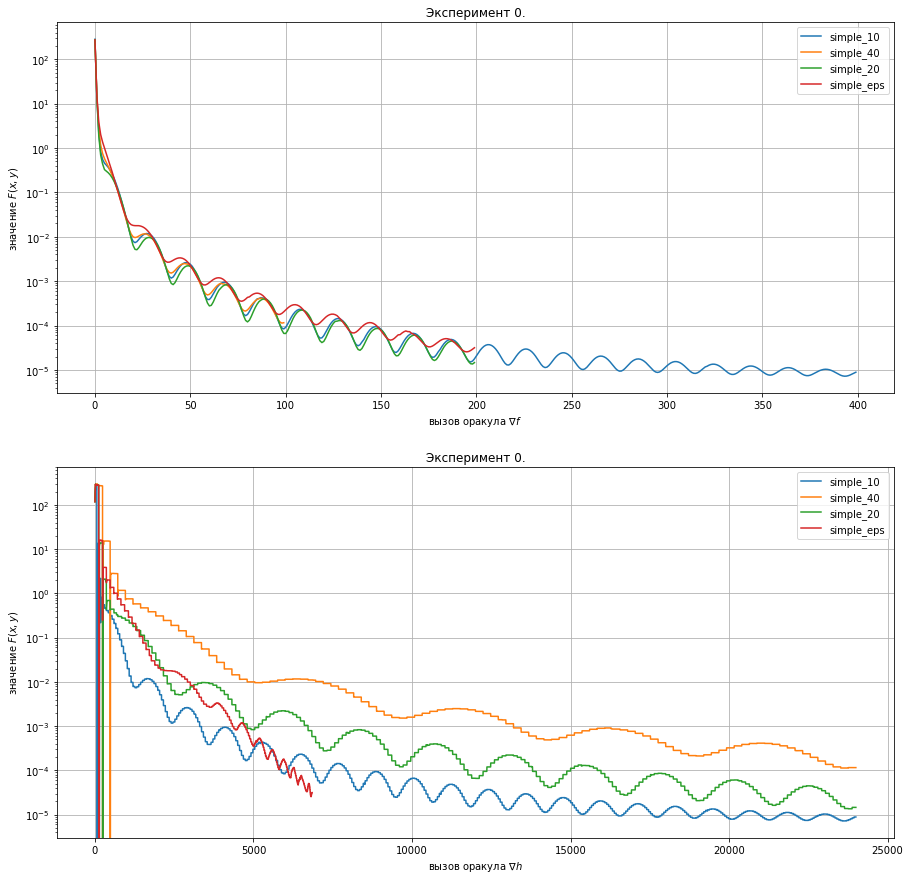

In [15]:
plt.figure(figsize=(15,15))

for i in range(len(exps)):
    ax = plt.subplot(2, 1, 1 + i * 2)
    ax.set_title('Эксперимент {}.'.format(i))
    
    Ff = collectFfromfOracleSimple(res_simple_10[i])
    ax.plot(range(len(Ff)), Ff, label='simple_10')
    
    Ff = collectFfromfOracleSimple(res_simple_40[i])
    ax.plot(range(len(Ff)), Ff, label='simple_40')
    
    Ff = collectFfromfOracleSimple(res_simple_20[i])
    ax.plot(range(len(Ff)), Ff, label='simple_20')
    
    Ff = collectFfromfOracleSimple(res_simple_eps[i])
    ax.plot(range(len(Ff)), Ff, label='simple_eps')
    
    #Ff = collectFfromfOracleSimple(res_simple_adaptive[i])
    #ax.plot(range(len(Ff)), Ff, label='simple_adaptive')
        
    plt.yscale("log")
    plt.ylabel('значение $F(x, y)$')
    plt.xlabel('вызов оракула $\\nabla f$')
    plt.grid(True)
    plt.legend()
    
    
    ax = plt.subplot(2, 1, 1 + i * 2 + 1)
    ax.set_title('Эксперимент {}.'.format(i))

    Fh = collectFfromhOracleSimple(res_simple_10[i])
    ax.plot(range(len(Fh)), Fh, label='simple_10')
    
    Fh = collectFfromhOracleSimple(res_simple_40[i])
    ax.plot(range(len(Fh)), Fh, label='simple_40')
    
    Fh = collectFfromhOracleSimple(res_simple_20[i])
    ax.plot(range(len(Fh)), Fh, label='simple_20')
    
    Fh = collectFfromhOracleSimple(res_simple_eps[i])
    ax.plot(range(len(Fh)), Fh, label='simple_eps')
    
    #Fh = collectFfromhOracleSimple(res_simple_adaptive[i])
    #ax.plot(range(len(Fh)), Fh, label='simple_adaptive')
    
    plt.yscale("log")
    plt.ylabel('значение $F(x, y)$')
    plt.xlabel('вызов оракула $\\nabla h$')
    plt.grid(True)
    plt.legend()
    
    

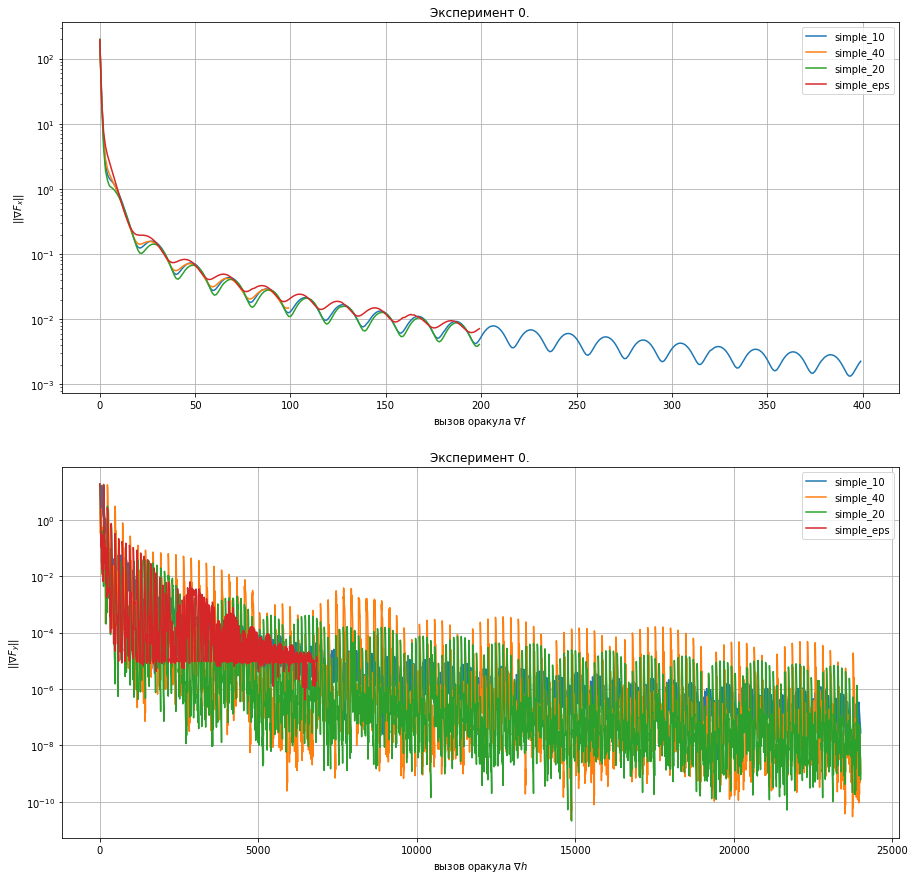

In [16]:
plt.figure(figsize=(15,15))

for i in range(len(exps)):
    ax = plt.subplot(2, 1, 1 + i * 2 + 0)
    ax.set_title('Эксперимент {}.'.format(i))

    Gf = collectGradNormfromfOracleSimple(res_simple_10[i])
    ax.plot(range(len(Gf)), Gf, label='simple_10')
    
    Gf = collectGradNormfromfOracleSimple(res_simple_40[i])
    ax.plot(range(len(Gf)), Gf, label='simple_40')
    
    Gf = collectGradNormfromfOracleSimple(res_simple_20[i])
    ax.plot(range(len(Gf)), Gf, label='simple_20')
    
    Gf = collectGradNormfromfOracleSimple(res_simple_eps[i])
    ax.plot(range(len(Gf)), Gf, label='simple_eps')
    
    #Gf = collectGradNormfromfOracleSimple(res_simple_adaptive[i])
    #ax.plot(range(len(Gf)), Gf, label='simple_adaptive')
    
    plt.yscale("log")
    plt.ylabel('$||\\nabla F_x||$')
    plt.xlabel('вызов оракула $\\nabla f$')
    plt.grid(True)
    plt.legend()
    
    
    ax = plt.subplot(2, 1, 1 + i * 2 + 1)
    ax.set_title('Эксперимент {}.'.format(i))

    Gh = collectGradNormfromhOracleSimple(res_simple_10[i])
    ax.plot(range(len(Gh)), Gh, label='simple_10')
    
    Gh = collectGradNormfromhOracleSimple(res_simple_40[i])
    ax.plot(range(len(Gh)), Gh, label='simple_40')
    
    Gh = collectGradNormfromhOracleSimple(res_simple_20[i])
    ax.plot(range(len(Gh)), Gh, label='simple_20')
    
    Gh = collectGradNormfromhOracleSimple(res_simple_eps[i])
    ax.plot(range(len(Gh)), Gh, label='simple_eps')
    
    #Gh = collectGradNormfromhOracleSimple(res_simple_adaptive[i])
    #ax.plot(range(len(Gh)), Gh, label='simple_adaptive')
    
    plt.yscale("log")
    plt.ylabel('$||\\nabla F_y||$')
    plt.xlabel('вызов оракула $\\nabla h$')
    plt.grid(True)
    plt.legend()


**Вывод**

simple_* имеют фиксированное число итераций для обоих метаалгоритмов, число означает кол-во итераций поиска по $y$ для одной итерации поиска по $x$.
simple_eps имеет проверку на норму градиента для остановки.


Здесь результат такой же, как и в квадратичных экспериментах, т.е. быстрее сходится метод, которые делает больше итераций внешнего алгоритма, поскольку в данном случае в f и h одинаковые.
При этом видно, что точность решения задачи по $x$ отличается мало, хотя simple_eps делает сильно меньше итераций вызовов $\nabla$.
Это приводит к выводу, что не обязательно решать внутреннюю задачу очень точно для достижения хороших результатов по $x$.


На графиках по $\nabla h$ есть вертикальные линии (на самом деле они не вертикальные, а так кажется из-за того, что они занимают мало итераций, при том, что на графике итераций десятки тысяч), которые возникают из-за того, что после сдвига по $x$ надо перерешивать задачу по $y$, поскольку он теперь не максимизирует функцию. Чем больше сдвиг по $x$ влияет на функцию, тем больше эти линии.

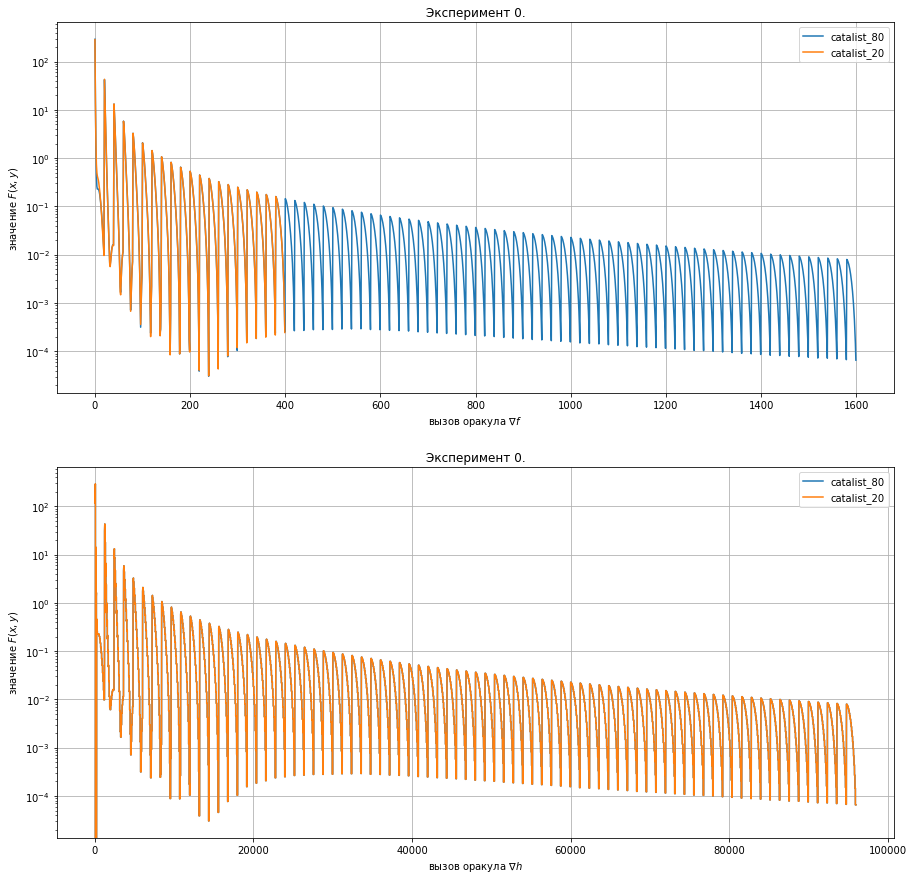

In [17]:
plt.figure(figsize=(15,15))

for i in range(len(exps)):
    ax = plt.subplot(2, 1, 1 + i * 2)
    ax.set_title('Эксперимент {}.'.format(i))
    
    Ff = collectFfromfOracleCatalist(res_catalist_80[i])
    ax.plot(range(len(Ff)), Ff, label='catalist_80')

    Ff = collectFfromfOracleCatalist(res_catalist_20[i])
    ax.plot(range(len(Ff)), Ff, label='catalist_20')
    
    plt.yscale("log")
    plt.ylabel('значение $F(x, y)$')
    plt.xlabel('вызов оракула $\\nabla f$')
    plt.grid(True)
    plt.legend()
    
    
    ax = plt.subplot(2, 1, 1 + i * 2 + 1)
    ax.set_title('Эксперимент {}.'.format(i))
    
    Fh = collectFfromhOracleCatalist(res_catalist_80[i])
    ax.plot(range(len(Fh)), Fh, label='catalist_80')
    
    Fh = collectFfromhOracleCatalist(res_catalist_80[i])
    ax.plot(range(len(Fh)), Fh, label='catalist_20')
    
    plt.yscale("log")
    plt.ylabel('значение $F(x, y)$')
    plt.xlabel('вызов оракула $\\nabla h$')
    plt.grid(True)
    plt.legend()
    

## **Вывод**


catalist_* имеет фиксированное число итераций для обоих метаалгоритмов, число означает кол-во итераций внешнего цикла алгоритма Каталист.

Видно, что здесь Каталист также сходится хуже, чему простой запуск седла.

Интересно, что графики Каталистов с разными настройками очень сильно сопадают.